## Training
Prepapre dataset with the prepare_dataset notebook, before running this one.

In [1]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from time import time, sleep
import numpy as np
import os
import warnings; warnings.filterwarnings("ignore")
from utils import *
  
# DEV = torch.device('cpu') # for debugging, use cpu
os.makedirs(f"{SAVE_DIR}", exist_ok=True)
print(f'DEV: {DEV}, has_screen: {LOCAL}, job id: {JOBID}')

# copy the python training to the directory (for cluster) (for local, it fails silently)
os.system(f"cp train.py {SAVE_DIR}/train.py")
os.system(f"cp utils.py {SAVE_DIR}/utils.py")

# SMALL, NORM, BIG = "small", "norm", "big"

Running JOBID: local, on cpu
DEV: cpu, has_screen: True, job id: local


cp: cannot stat 'train.py': No such file or directory


0

In [ ]:

EPOCHS = 12 if LOCAL else 40 # number of epochs # 1000
# BATCH_SIZE = 128 # 128 
BATCH_SIZE = 16 if LOCAL else 64 # 64 <-

λ1, λ2, λ3 = 1.0, 1e-10, 2.0 # loss weights for y1, y2, y3

# LOAD_PRETRAINED = "trained_models/pretrained_1809761.pth" # norm model
# LOAD_PRETRAINED = CURR_EVAL_MODEL if LOCAL else None # pretrained model
LOAD_PRETRAINED = None # Set it to None if you don't want to load pretrained model

# LEARNING_RATE = 3e-4*np.logspace(0, -2, EPOCHS) 
# LEARNING_RATE = 3e-3*np.ones(EPOCHS) 
# LEARNING_RATE = 3e-3*np.logspace(0, -2, EPOCHS)  
LEARNING_RATE = 1e-3*np.logspace(0, -2, EPOCHS) # <-
# LEARNING_RATE = 3e-4*np.ones(EPOCHS) 

# GSO_LOSS_RATIO = np.concatenate((np.linspace(1e-6, 3e-3, EPOCHS//2), np.linspace(3e-3, 0.0, EPOCHS//2))) 
MAX_GSO = 5e-3 # 3e-3 <-
GSO_LOSS_RATIO = np.concatenate((np.linspace(1e-6, MAX_GSO, EPOCHS//4), 
                                 np.linspace(MAX_GSO, MAX_GSO, EPOCHS//4), 
                                 np.linspace(MAX_GSO, 0.0, EPOCHS//4), 
                                 np.linspace(0.0, 0.0, EPOCHS//4))) # <-
# GSO_LOSS_RATIO = np.concatenate((MAX_GSO*np.logspace(-6, 0, EPOCHS//4), 
#                                  MAX_GSO*np.logspace(0, 0, EPOCHS//4), 
#                                  MAX_GSO*np.logspace(0, -10, EPOCHS//4), 
#                                  np.logspace(-12, -12, EPOCHS//4))) 
# GSO_LOSS_RATIO = np.zeros(EPOCHS) 

In [3]:
#checks
if LOAD_PRETRAINED is not None: assert os.path.exists(LOAD_PRETRAINED), "Pretrained model does not exist"
assert os.path.exists(TRAIN_DS_PATH), "Training dataset does not exist"
assert os.path.exists(EVAL_DS_PATH), "Evaluation dataset does not exist"
assert os.path.exists(SAVE_DIR), "Save directory does not exist"
assert len(LEARNING_RATE) == EPOCHS, "Learning rate array length does not match epochs"
assert len(GSO_LOSS_RATIO) == EPOCHS, "GSO loss ratio array length does not match epochs"

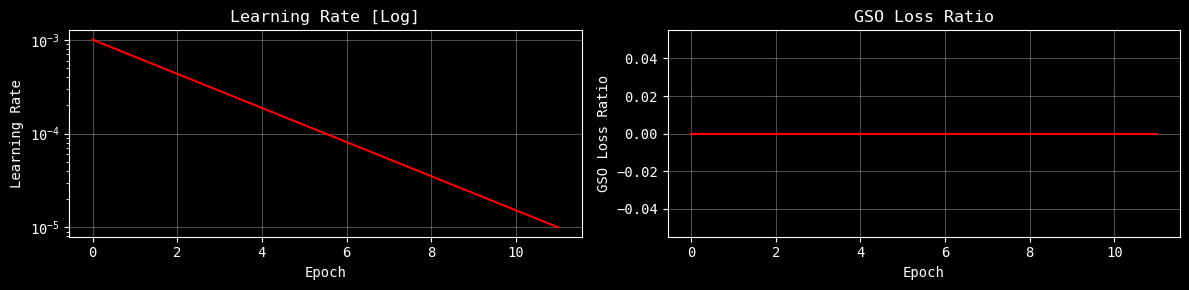

In [4]:
# plot schedulers: lr + gso loss ratio
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].set_title("Learning Rate [Log]")
ax[0].plot(LEARNING_RATE, color="red")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Learning Rate")
ax[0].set_yscale("log")
ax[1].set_title("GSO Loss Ratio")
ax[1].plot(GSO_LOSS_RATIO, color="red")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("GSO Loss Ratio")
plt.tight_layout()
plt.show() if LOCAL else plt.savefig(f"{SAVE_DIR}/schedulers.png")

Dataset: N:16000, memory:57.408MB, on_dev:False
Dataset: N:4000, memory:14.352MB, on_dev:False
test_dataset
Dataset: N:4000, memory:14.352MB, on_dev:False
Dataset length: 4000
Inputs: X -> torch.Size([95]), r -> torch.Size([16]), z -> torch.Size([16])
Outputs: Y1 -> torch.Size([1, 16, 16]), Y2 -> torch.Size([1, 16, 16]), Y3 -> torch.Size([258])
4000


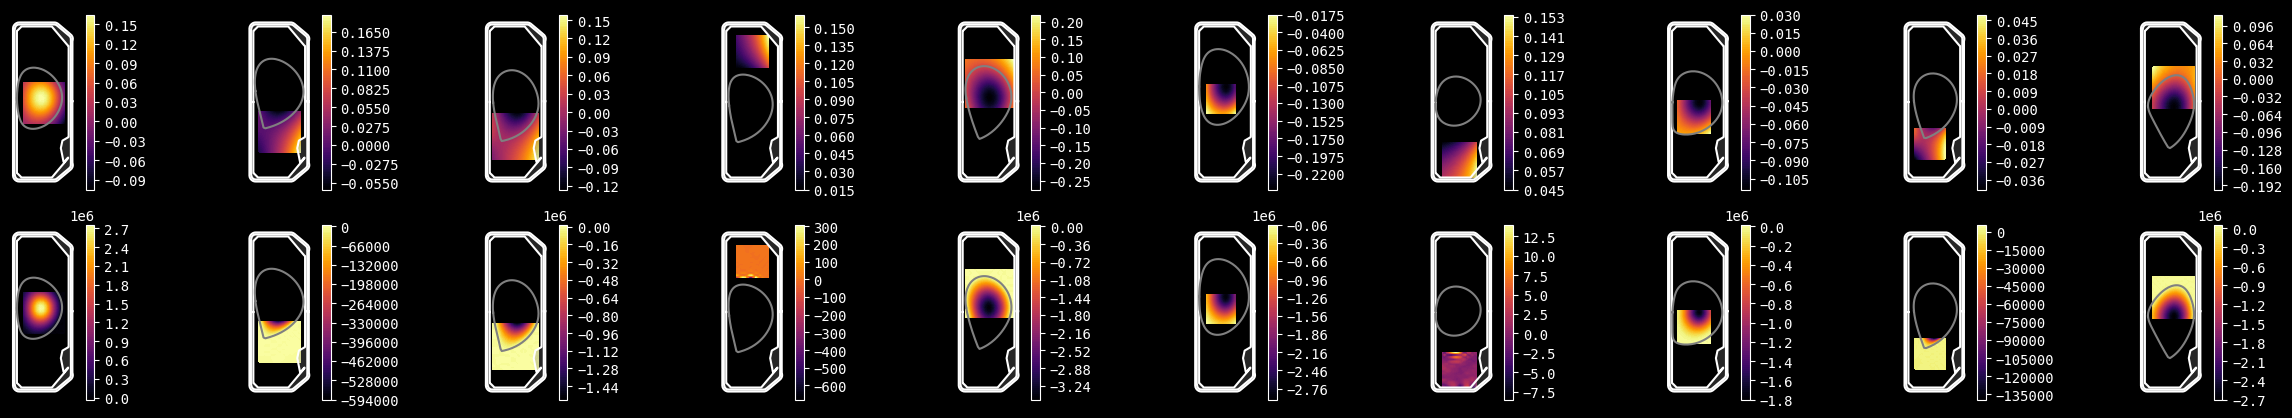

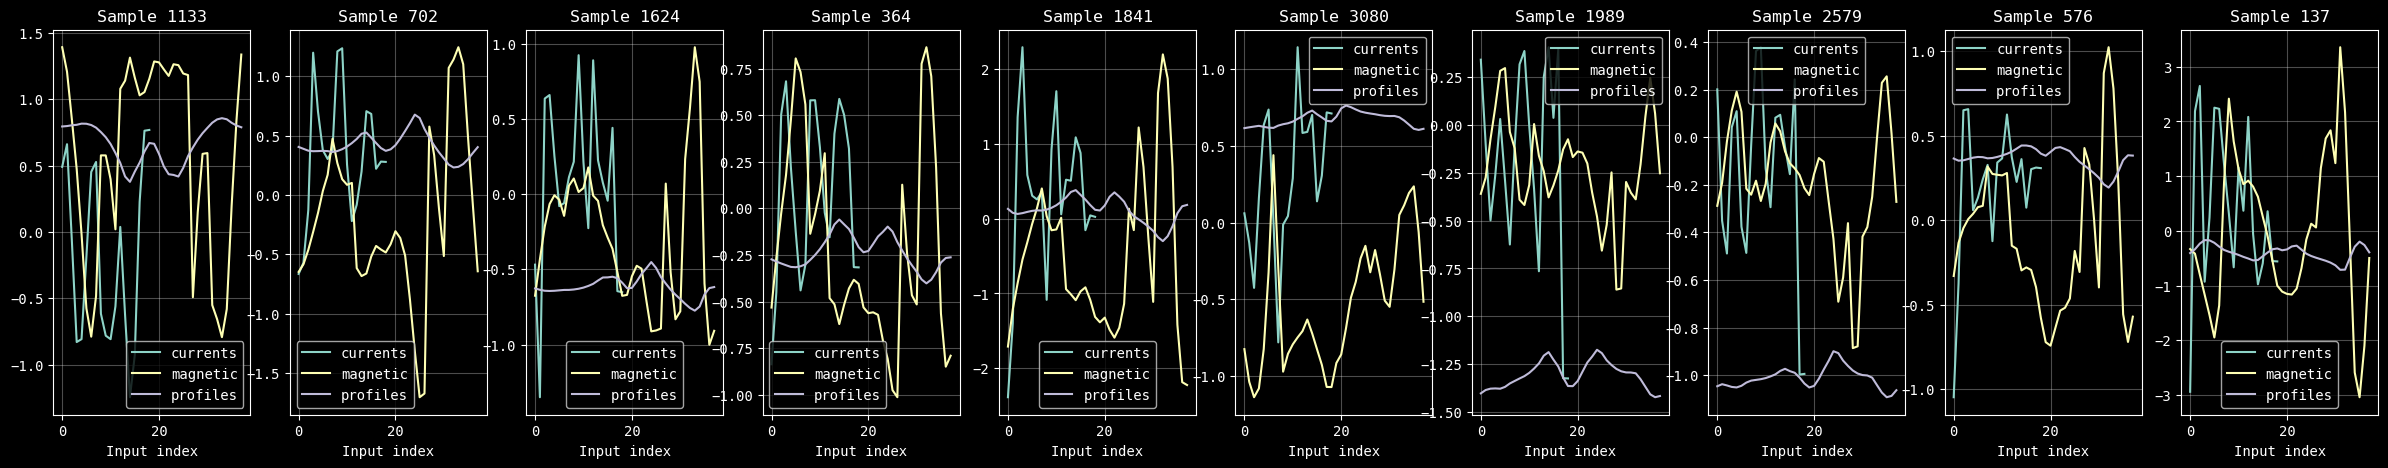

In [5]:
# create training and evaluation datasets
train_ds = LiuqeDataset(TRAIN_DS_PATH)
val_ds = LiuqeDataset(EVAL_DS_PATH)
test_dataset()

In [6]:
# test net I/O
test_network_io()

test_network_io
lol
lol
LiuqeNet -> in: torch.Size([1, 95]), torch.Size([1, 16]), torch.Size([1, 16]), 
            out: torch.Size([1, 1, 16, 16]), torch.Size([1, 1, 16, 16]), torch.Size([1, 258])
LCFSNet  -> in: torch.Size([1, 95]), 
            out: torch.Size([1, 258])
LiuqeNet -> in: torch.Size([7, 95]), torch.Size([7, 16]), torch.Size([7, 16]), 
            out: torch.Size([7, 1, 16, 16]), torch.Size([7, 1, 16, 16]), torch.Size([7, 258])
LCFSNet  -> in: torch.Size([7, 95]), 
            out: torch.Size([7, 258])


## Training

In [7]:
def train():
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # initialize DataLoader
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)  
    # network
    model = LiuqeNet(InputNet(), GridNet(), FluxHead(), FluxHead(), LCFSHead()) # initialize model
    if LOAD_PRETRAINED is not None: # load pretrained model
        model.load_state_dict(torch.load(LOAD_PRETRAINED, map_location=torch.device("cpu")), strict=STRICT_LOAD) # load pretrained model
        print(f"Pretrained model loaded: {LOAD_PRETRAINED}")
    model.to(DEV) # move model to DEV
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE[0])
    loss_fn = torch.nn.MSELoss() # Mean Squared Error Loss
    tlog, elog = np.inf*np.ones((EPOCHS, len(train_dl), len(LOSS_NAMES))), np.inf*np.ones((EPOCHS, len(val_dl), len(LOSS_NAMES))) # init logs
    start_time = time() # start time
    for ep in range(EPOCHS): # epochs
        epoch_time = time()
        for pg in optimizer.param_groups: pg['lr'] = LEARNING_RATE[ep] # update learning rate
        # train_ep_loss, eval_ep_loss = 1000*np.ones((len(train_dl), len(LOSS_NAMES))), 1000*np.ones((len(val_dl), len(LOSS_NAMES))) # init epoch losses
        model.train()
        for ib, batch in enumerate(train_dl):
            if train_ds.on_dev: x, r, z, y1, y2, y3 = batch # unpack batch
            else: x, r, z, y1, y2, y3 = map(lambda t: t.to(DEV), batch) # move to DEV
            optimizer.zero_grad() # zero gradients
            yp1, yp2, yp3 = model(x, r, z) # forward pass
            gso, gsop = calc_gso_batch(y1, r, z, dev=DEV), calc_gso_batch(yp1, r, z, dev=DEV) # calculate grad shafranov
            # losses
            l1 = loss_fn(y1, yp1) 
            l2 = loss_fn(y2, yp2) 
            l3 = loss_fn(y3, yp3) 
            lgso = loss_fn(gsop, gso) # PINN loss on grad shafranov
            loss = λ1*l1 + λ2*l2 + λ3*l3 + GSO_LOSS_RATIO[ep]*lgso # total loss
            loss.backward() # backprop
            optimizer.step() # update weights 
            tlog[ep, ib] = (l1.item(), l2.item(), l3.item(), lgso.item()) # save batch losses
        model.eval() # evaluation mode
        with torch.no_grad():
            for ib, batch in enumerate(val_dl):
                if val_ds.on_dev: x, r, z, y1, y2, y3 = batch # unpack batch
                else: x, r, z, y1, y2, y3 = map(lambda t: t.to(DEV), batch) # move to DEV
                yp1, yp2, yp3 = model(x, r, z) # forward pass
                gso, gsop = calc_gso_batch(y1, r, z, dev=DEV), calc_gso_batch(yp1, r, z, dev=DEV)
                # losses
                l1 = loss_fn(y1, yp1)
                l2 = loss_fn(y2, yp2)
                l3 = loss_fn(y3, yp3)
                lgso = loss_fn(gsop, gso)
                assert not torch.isnan(l1) and not torch.isnan(l2) and not torch.isnan(l3) and not torch.isnan(lgso), "Loss is NaN"
                elog[ep, ib] = (l1.item(), l2.item(), l3.item(), lgso.item()) # save batch losses
        # save model if improved        
        endp = " " 
        epoch_losses = np.mean(elog[ep,:,:], axis=0) # epoch losses: mean across batchess
        best_losses = np.min(np.mean(elog[:ep,:,:], axis=1), axis=0) if ep > 0 else epoch_losses # best losses: min across epochs
        for el, bl, n in zip(epoch_losses, best_losses, LOSS_NAMES):
            if el <= bl: torch.save(model.state_dict(), model_path(n)); endp+=f"[{n}]"
        # print progress
        print(f"[{ep+1:03d}/{EPOCHS:03d}] " +
            "Eval -> " + ', '.join([f"{n} {v:.0e}" for n, v in zip(LOSS_NAMES, epoch_losses)]) + " | " +
            f"lr {LEARNING_RATE[ep]:.0e}, r {GSO_LOSS_RATIO[ep]:.0e}, {int(time()-epoch_time):02d}s, eta {int((time()-start_time)*(EPOCHS-ep)/(ep+1)/60):03d}m", end=endp+'\n')
        if ep >= 10 and best_losses[0] > 0.2: return False # stop training, if not converging, try again

    tlosses, elosses = np.mean(tlog, axis=1), np.mean(elog, axis=1) # losses across epochs
    print(f"Training time: {(time()-start_time)/60:.0f}mins")
    print("Best losses  : " + ", ".join([f"{n} {bl:.0e} (ep {be})" for n, bl, be in zip(LOSS_NAMES, np.min(elosses, axis=0), np.argmin(elosses, axis=0))]))
    print("Estimated MAE: " + ", ".join([f"{n} {np.sqrt(np.min(np.mean(elog[:,:,i], axis=1))):.3e}" for i, n in enumerate(LOSS_NAMES)]))
    np.save(f"{SAVE_DIR}/train_losses.npy", tlosses) # save training losses
    np.save(f"{SAVE_DIR}/eval_losses.npy", elosses) # save evaluation losses
    return True

# train the model (multiple attempts)
for i in range(20): 
    print('Starting training...')
    success = train()
    if success: break
    else: print(f"Convergence failed, retrying... {i+1}/20")
# if not success: delete the files and exit:
if not success: os.system(f"rm -rf {SAVE_DIR}")
assert success, "Training failed, no model saved"

Starting training...
[001/012] Eval -> l1 8e-03, l2 5e+11, l3 6e-03, gso 3e+01 | lr 1e-03, r 0e+00, 09s, eta 001m [l1][l2][l3][gso]
[002/012] Eval -> l1 8e-03, l2 5e+11, l3 6e-03, gso 4e+01 | lr 7e-04, r 0e+00, 10s, eta 001m [l2]
[003/012] Eval -> l1 8e-03, l2 5e+11, l3 6e-03, gso 4e+01 | lr 4e-04, r 0e+00, 10s, eta 001m [l2]
[004/012] Eval -> l1 8e-03, l2 5e+11, l3 6e-03, gso 3e+01 | lr 3e-04, r 0e+00, 10s, eta 001m [l2][l3][gso]
[005/012] Eval -> l1 8e-03, l2 5e+11, l3 6e-03, gso 3e+01 | lr 2e-04, r 0e+00, 10s, eta 001m [l2]
[006/012] Eval -> l1 8e-03, l2 5e+11, l3 6e-03, gso 3e+01 | lr 1e-04, r 0e+00, 10s, eta 001m [l3]
[007/012] Eval -> l1 8e-03, l2 5e+11, l3 6e-03, gso 3e+01 | lr 8e-05, r 0e+00, 09s, eta 001m [l3]
[008/012] Eval -> l1 8e-03, l2 5e+11, l3 6e-03, gso 3e+01 | lr 5e-05, r 0e+00, 10s, eta 000m [l3]
[009/012] Eval -> l1 8e-03, l2 5e+11, l3 6e-03, gso 3e+01 | lr 4e-05, r 0e+00, 10s, eta 000m [l3]
[010/012] Eval -> l1 8e-03, l2 5e+11, l3 6e-03, gso 3e+01 | lr 2e-05, r 0e+

Plotting losses...


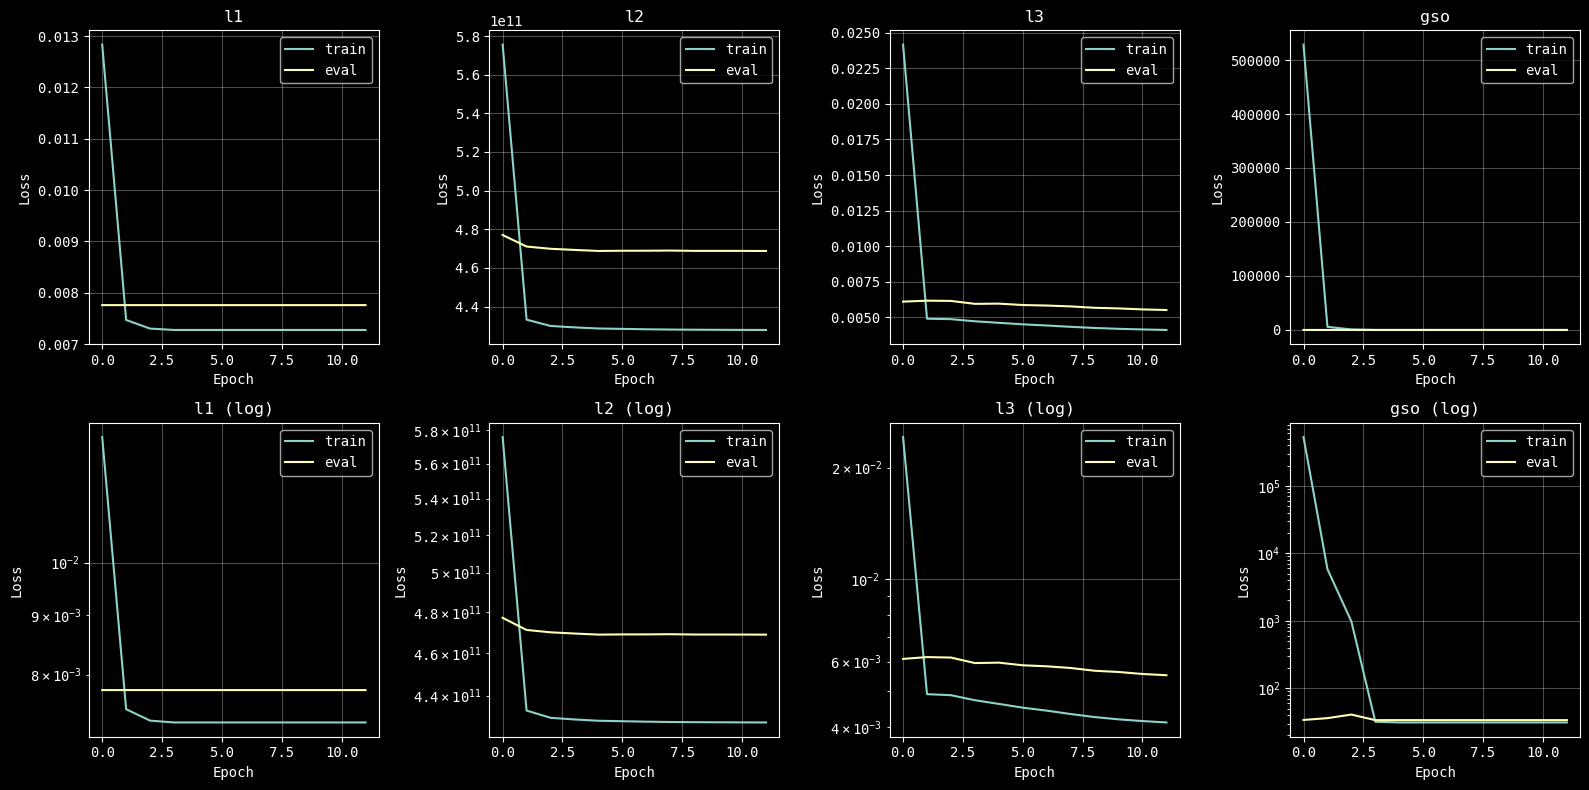

In [8]:
# plot losses
print("Plotting losses...")

fig, ax = plt.subplots(2, len(LOSS_NAMES), figsize=(4*len(LOSS_NAMES), 8))
# Load losses
train_loss = np.load(f"{SAVE_DIR}/train_losses.npy")
eval_loss = np.load(f"{SAVE_DIR}/eval_losses.npy")
for i, name in enumerate(LOSS_NAMES):
    # Linear scale
    ax[0, i].plot(train_loss[:,i], label='train')
    ax[0, i].plot(eval_loss[:,i], label='eval')
    ax[0, i].set_title(f"{name}")
    ax[0, i].set_xlabel("Epoch")
    ax[0, i].set_ylabel("Loss")
    ax[0, i].legend(); ax[0, i].grid(True)
    # Log scale
    ax[1, i].plot(train_loss[:,i], label='train')
    ax[1, i].plot(eval_loss[:,i], label='eval')
    ax[1, i].set_yscale('log')
    ax[1, i].set_title(f"{name} (log)")
    ax[1, i].set_xlabel("Epoch")
    ax[1, i].set_ylabel("Loss")
    ax[1, i].legend(); ax[1, i].grid(True)
plt.tight_layout()
plt.show() if LOCAL else plt.savefig(f"{SAVE_DIR}/losses.png")

Testing network output...


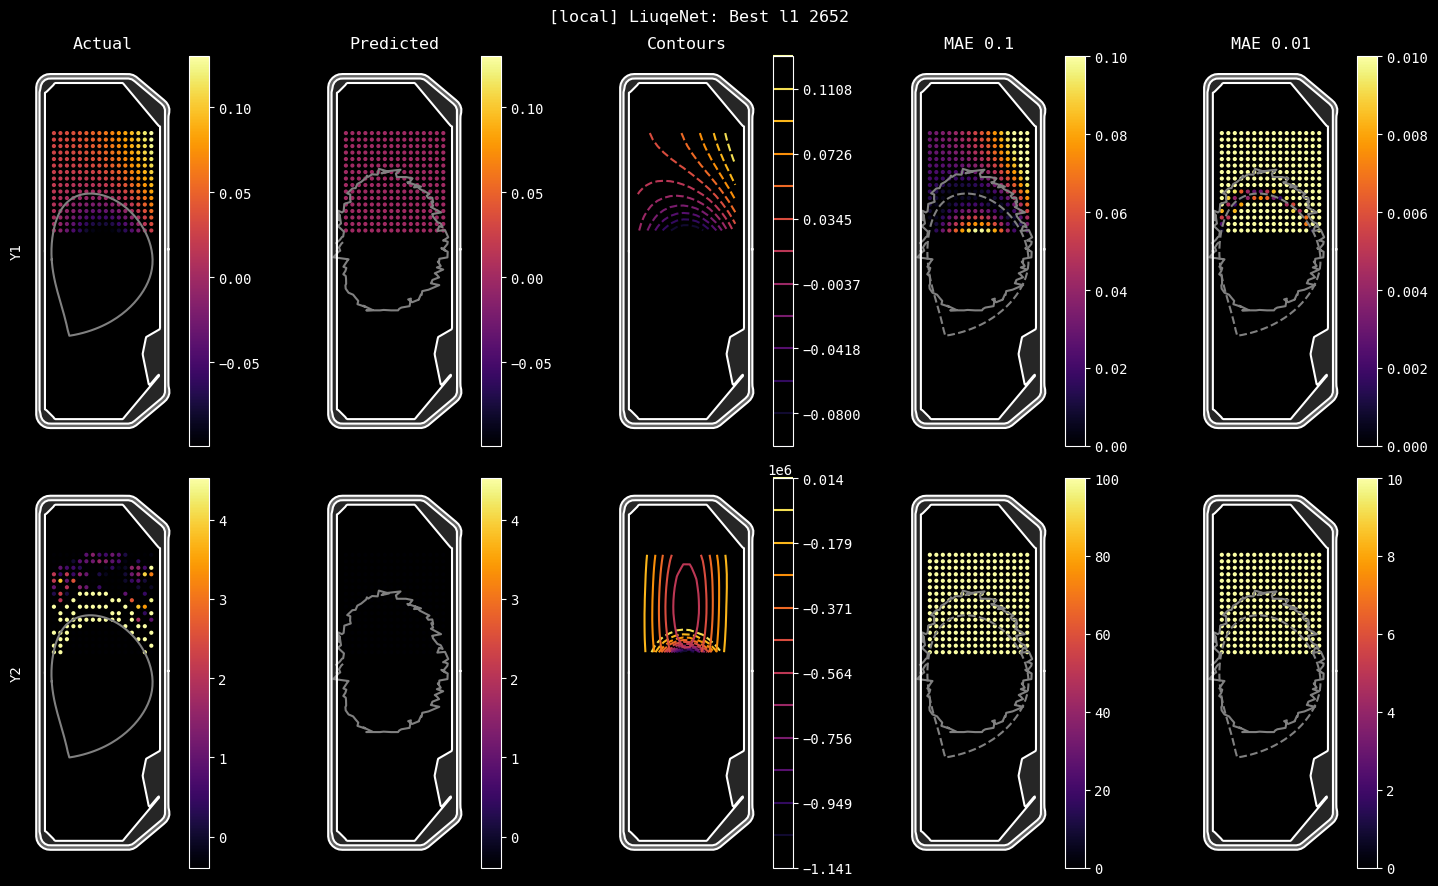

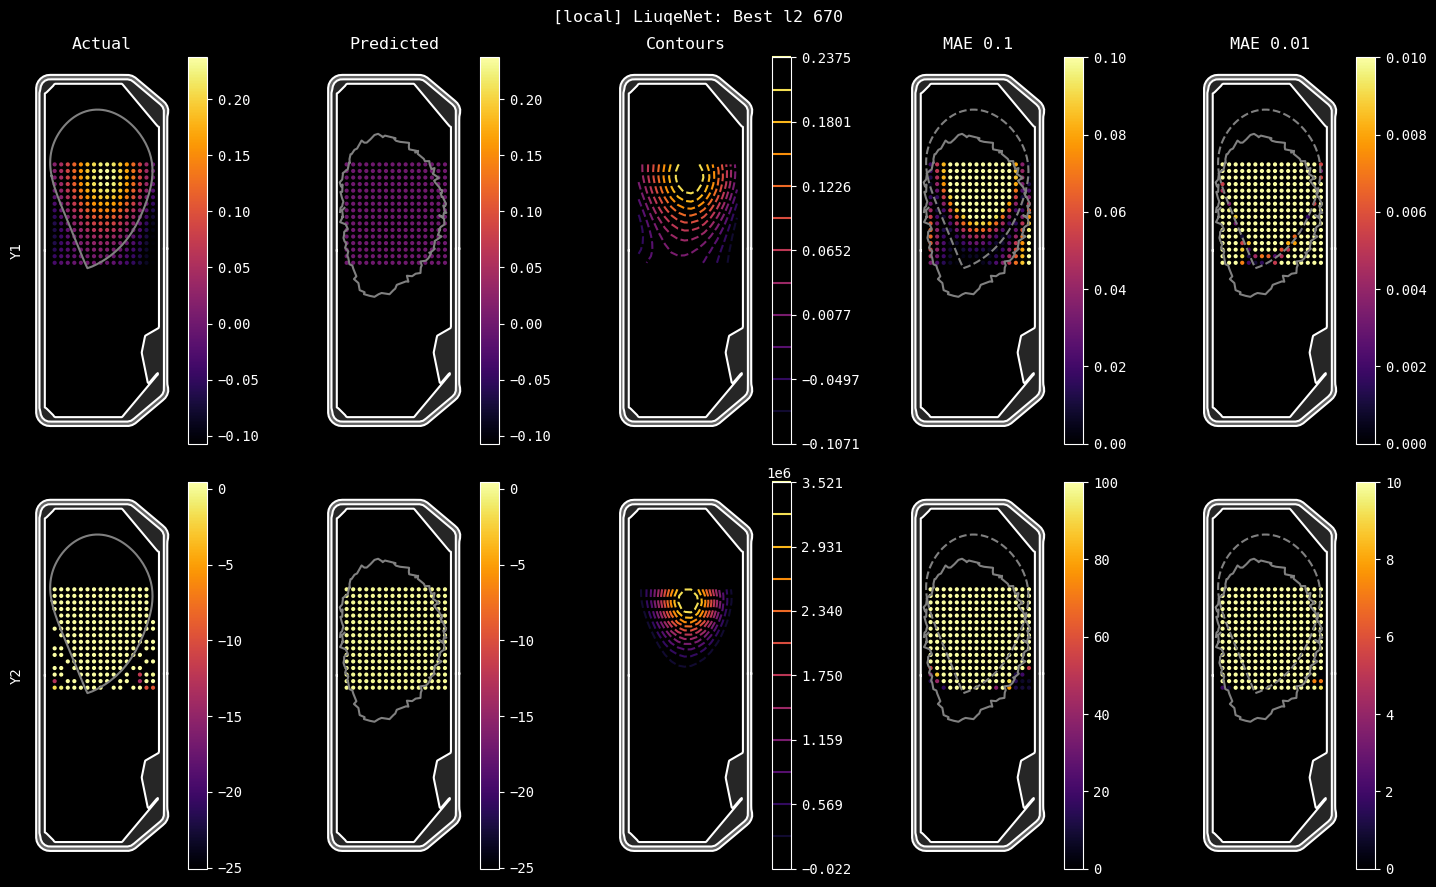

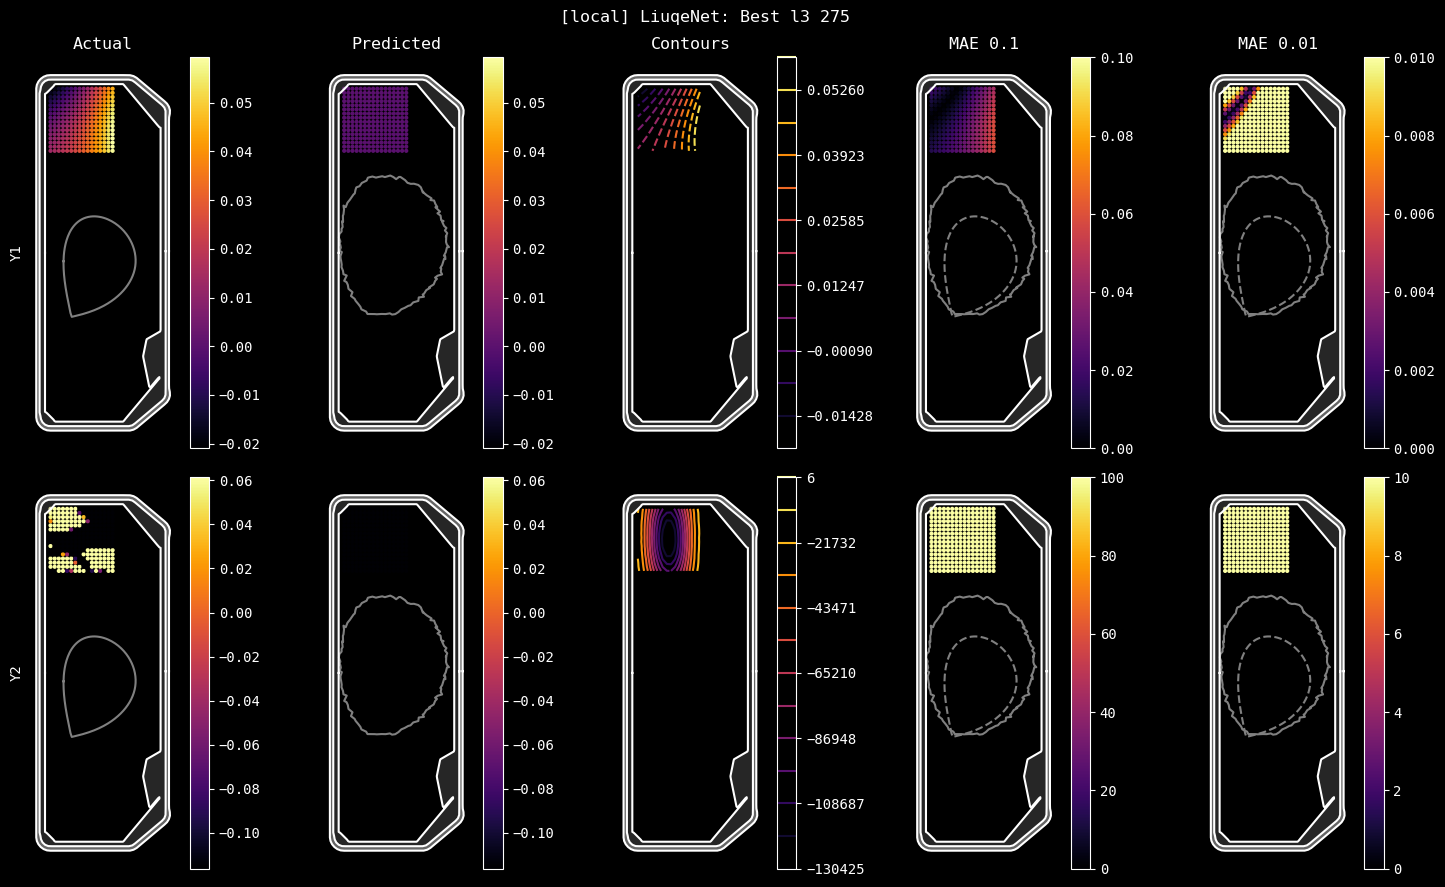

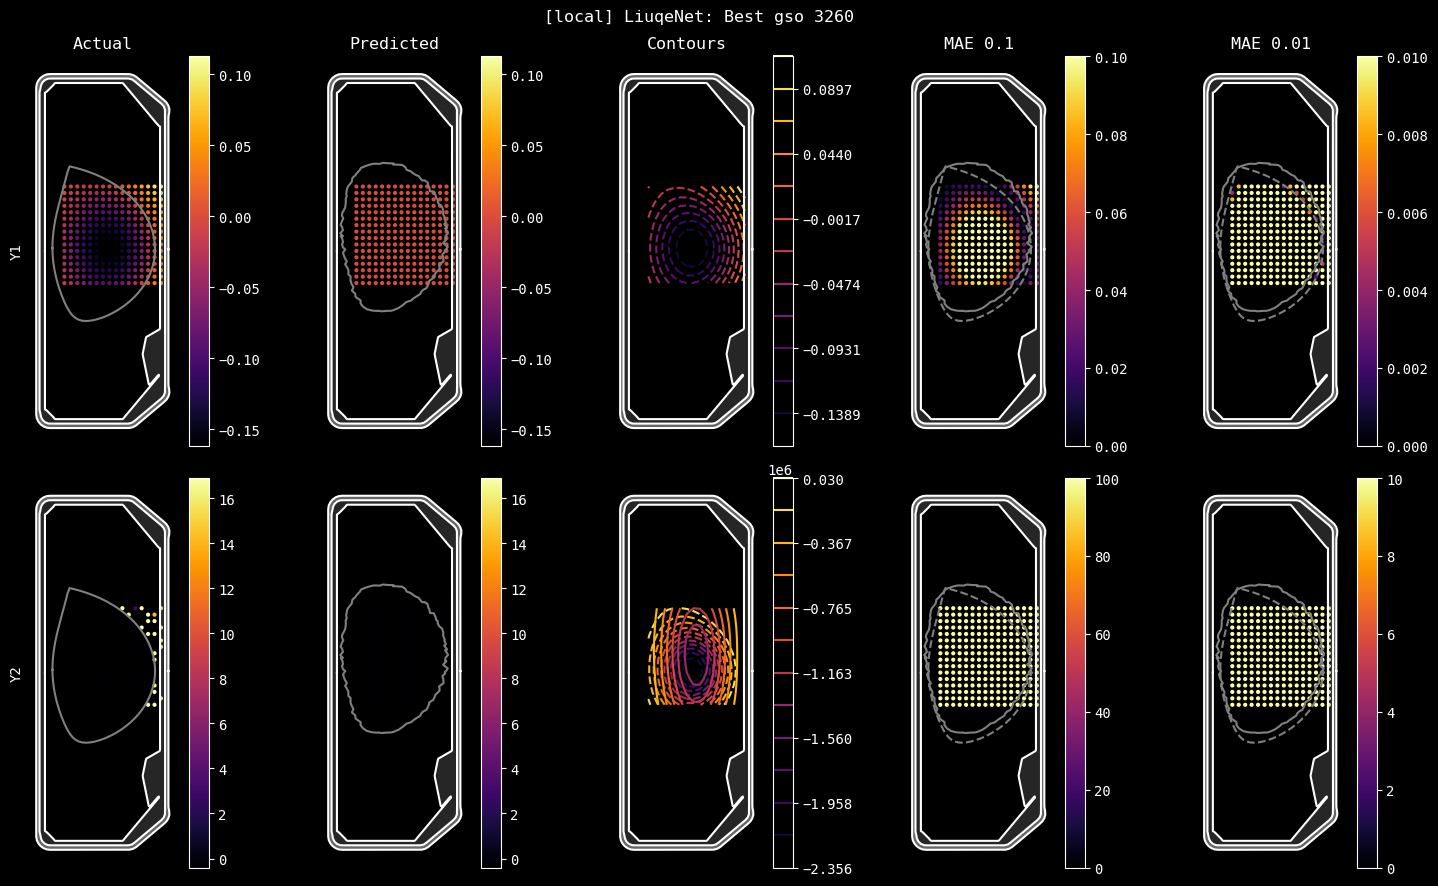

In [9]:
# testing network output
print("Testing network output...")
for ln in LOSS_NAMES:
    model = LiuqeNet(InputNet(), GridNet(), FluxHead(), FluxHead(), LCFSHead()) # initialize model
    model.load_state_dict(torch.load(model_path(ln), map_location=torch.device("cpu"))) # load pretrained model
    plot_network_outputs(val_ds, model, title=f'Best {ln}') # plot network outputs

In [10]:
# test inference speed
print("Testing inference speed...")
model = LiuqeNet(InputNet(), GridNet(), FluxHead(), FluxHead(), LCFSHead()) # initialize model
model.load_state_dict(torch.load(model_path(LOSS_NAMES[2]), map_location=torch.device("cpu"))) # load pretrained model
model.eval()
ds = val_ds
n_samples = 100
random_idxs = np.random.choice(n_samples, len(ds))
#cpu
cpu_times1, cpu_times2 = [], []
for i in random_idxs:
    start_t = time()
    x, r, z, y1, y2, y3 = ds[i]
    x, r, z = x.to('cpu'), r.to('cpu'), z.to('cpu')
    x = x.view(1, -1)
    r = r.view(1, NGZ)
    z = z.view(1, NGR)
    start_t2 = time()
    yp = model(x, r, z)
    end_t = time()
    cpu_times1.append(end_t - start_t)
    cpu_times2.append(end_t - start_t2)
# DEV
model.to(DEV)
dev_times1, dev_times2 = [], []
for i in random_idxs:
    x, r, z, y1, y2, y3 = ds[i]
    x, r, z = x.to(DEV), r.to(DEV), z.to(DEV)
    x = x.view(1, -1)
    r = r.view(1, NGZ)
    z = z.view(1, NGR)
    start_t = time()
    start_t2 = time()
    yp = model(x, r, z)
    end_t = time()
    dev_times1.append(end_t - start_t)
    dev_times2.append(end_t - start_t2)
cpu_times1, dev_times1 = np.array(cpu_times1)*1000, np.array(dev_times1)*1000
cpu_times2, dev_times2 = np.array(cpu_times2)*1000, np.array(dev_times2)*1000
print(f"cpu: inference time: [full -> {cpu_times1.mean():.5f}ms, std: {cpu_times1.std():.5f}]")
print(f"cpu: inference time: [inference only -> {cpu_times2.mean():.5f}ms, std: {cpu_times2.std():.5f}]")
print(f"dev: inference time: [full -> {dev_times1.mean():.5f}ms, std: {dev_times1.std():.5f}]")
print(f"dev: inference time: [inference only -> {dev_times2.mean():.5f}ms, std: {dev_times2.std():.5f}]")

Testing inference speed...
cpu: inference time: [full -> 0.22697ms, std: 0.01834]
cpu: inference time: [inference only -> 0.21710ms, std: 0.01754]
dev: inference time: [full -> 0.23060ms, std: 0.03040]
dev: inference time: [inference only -> 0.23051ms, std: 0.03039]


In [11]:
print(f"{JOBID} done")
if not LOCAL: sleep(30) # wait for files to update (for cluster)
#copy the log file to the folder
os.system(f"cp jobs/{JOBID}.txt {SAVE_DIR}/log.txt")

local done


cp: cannot stat 'jobs/local.txt': No such file or directory


256